<a href="https://colab.research.google.com/github/Silvia29/segy_proj/blob/master/segy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install segyio

In [8]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  2 12:59:58 2019

@author: zwartjpm
"""
import pandas as pd
import os
from tqdm import tqdm
import sys
import socket
machine=socket.gethostname()

sys.path.insert(0,'/content/drive/My Drive/segy/scripts')
data_dir  ='/content/drive/MyDrive/segy/sample_data/'
model_dir = '/content/drive/MyDrive/segy/model/'

#data_prefix       = 'vz_model_'
data_suffix_sembl = '_sembl.sgy'
data_suffix_velan = '_velan.sgy'
model_prefix      = 'model_'
model_suffix      = '_velan.sgy'

#==========================================================================
# xdir, positive offsets
#==========================================================================
#nd_files=len([file for  file in os.listdir(data_dir) if file.endswith('.sgy')])
#nm_files=len([file for file in os.listdir(model_dir) if file.endswith('.sgy')])
nd_sembl_files=0
for file in os.listdir(data_dir):
    if file.endswith(data_suffix_sembl):
        #if file.startswith(data_prefix):
        nd_sembl_files+=1

nd_velan_files=0
for file in os.listdir(data_dir):
    if file.endswith(data_suffix_velan):
    #if file.startswith(data_prefix):
        nd_velan_files+=1

nm_files=0
for file in os.listdir(model_dir):
    if file.endswith(model_suffix ):
        if file.startswith(model_prefix):
            nm_files+=1

#nfiles = max(nm_files, nd_files) + 1
nfiles = 10000
df_velan = pd.DataFrame(index=range(nfiles),columns=["num","shot","sembl","model"])

for file in os.listdir(data_dir):
    if file.endswith(data_suffix_sembl):
      #if file.startswith(data_prefix):
            #print(file)
          num = int(file.split('_')[-2])
            #print(num,file)
          df_velan.iloc[num]["num"] = num
          df_velan.iloc[num]["sembl"] = data_dir+file

for file in os.listdir(data_dir):
    if file.endswith(data_suffix_velan):
      #if file.startswith(data_prefix):
            #print(file)
          num = int(file.split('_')[-2])
            #print(num,file)
          df_velan.iloc[num]["num"] = num
          df_velan.iloc[num]["shot"] = data_dir+file

for file in os.listdir(model_dir):
    if file.endswith(model_suffix):
        if file.startswith(model_prefix):
            #print(file)
            num = int(file.split('_')[1])
            #print(num,file)
            df_velan.iloc[num]["num"] = num
            df_velan.iloc[num]["model"] = model_dir+file

df_velan.sort_values(by=['num'],inplace=True)
df_velan.dropna(axis=0, how='any', inplace=True)
df_velan.reset_index(inplace=True,drop=True)
df_velan.to_csv('Example_segy.csv', index=False)

print("Number of data/model files = ",len(df_velan))



Number of data/model files =  5


In [9]:
df=pd.read_csv('Example_segy.csv')
df.head()

,num,shot,sembl,model
0,0,/content/drive/MyDrive/segy/sample_data/shot_0...,/content/drive/MyDrive/segy/sample_data/shot_0...,/content/drive/MyDrive/segy/model/model_0_vela...
1,1,/content/drive/MyDrive/segy/sample_data/shot_1...,/content/drive/MyDrive/segy/sample_data/shot_1...,/content/drive/MyDrive/segy/model/model_1_vela...
2,2,/content/drive/MyDrive/segy/sample_data/shot_2...,/content/drive/MyDrive/segy/sample_data/shot_2...,/content/drive/MyDrive/segy/model/model_2_vela...
3,3,/content/drive/MyDrive/segy/sample_data/shot_3...,/content/drive/MyDrive/segy/sample_data/shot_3...,/content/drive/MyDrive/segy/model/model_3_vela...
4,4,/content/drive/MyDrive/segy/sample_data/shot_4...,/content/drive/MyDrive/segy/sample_data/shot_4...,/content/drive/MyDrive/segy/model/model_4_vela...


Checking if all shot files exist
Checking if all sembl files exist
Checking if all model files exist
file =  /content/drive/MyDrive/segy/sample_data/shot_4_velan.sgy
File is memory mapped!
SEGY file               =  /content/drive/MyDrive/segy/sample_data/shot_4_velan.sgy
Sampling interval       =  4.0
Number of traces        =  601
Number of samples       =  976
Initial shape of trace header array =  (601, 91)
Drop the duplicates and columns with constant values, except the keep_hdrs
The following 85 columns were removed
{'TransductionUnit', 'CDP_X', 'GroupStaticCorrection', 'WeatheringVelocity', 'ShotPointScalar', 'SourceGroupScalar', 'TraceWeightingFactor', 'SourceDatumElevation', 'DayOfYear', 'GroupY', 'TaperType', 'TRACE_SAMPLE_COUNT', 'LowCutFrequency', 'ScalarTraceHeader', 'OverTravel', 'TransductionConstantPower', 'GroupWaterDepth', 'SecondOfMinute', 'SourceY', 'LagTimeA', 'SourceSurfaceElevation', 'INLINE_3D', 'YearDataRecorded', 'ReceiverDatumElevation', 'TraceIdentifier', 'T

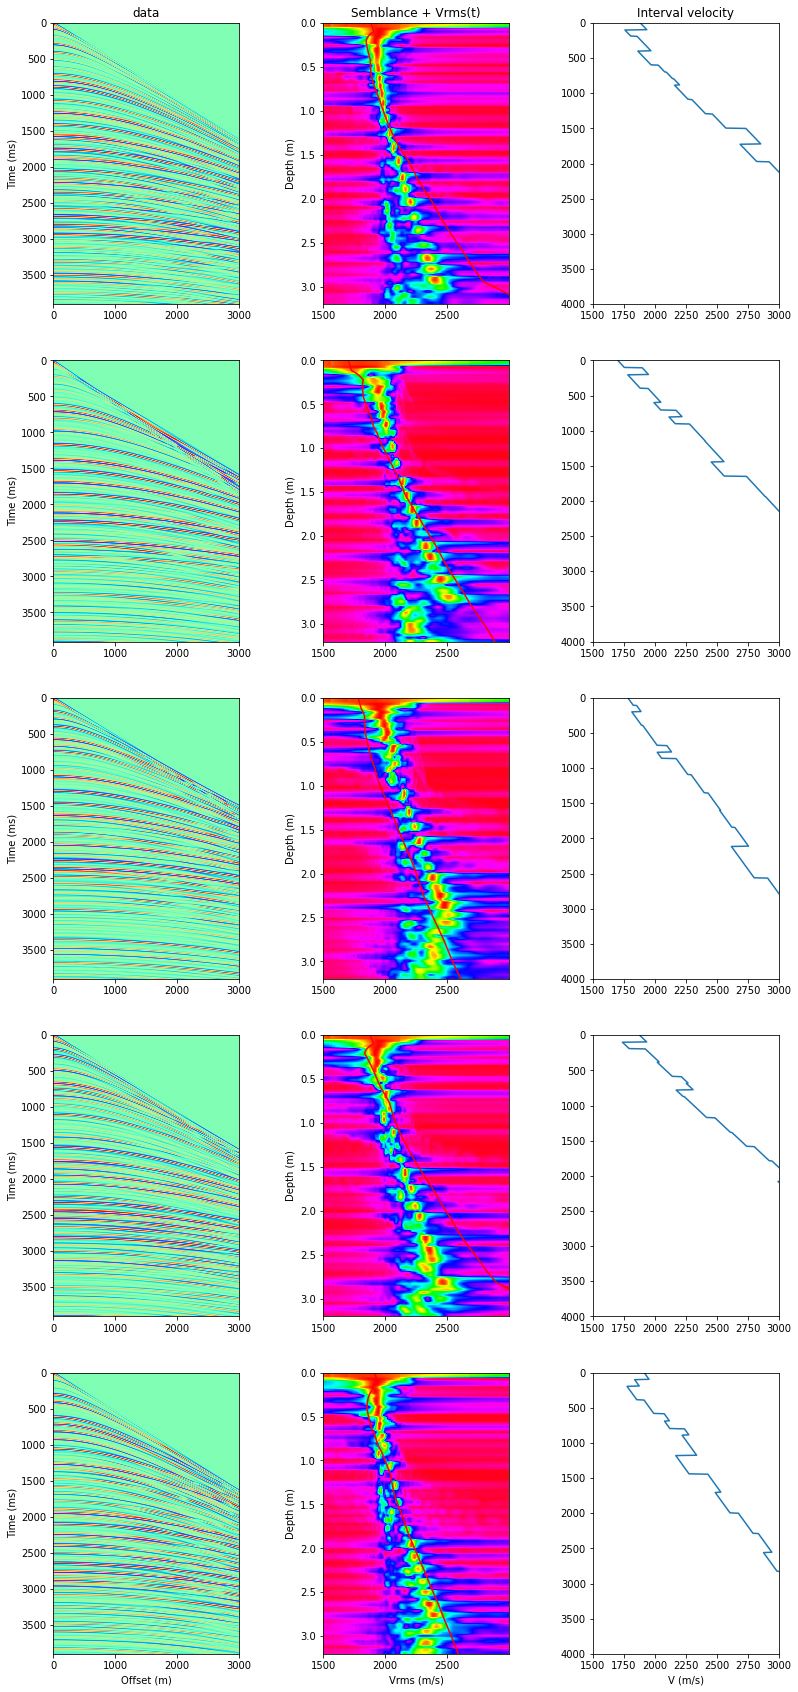

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Paul Zwartjes
"""

## Importing the necessary libraries
## Importing the necessary libraries
import os
import random
import sys
import socket
machine=socket.gethostname()

os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import tensorflow        as tf

from tensorflow.python.client      import device_lib
sys.path.append('/content/drive/MyDrive/segy')

#import seisplot
import gains

from importlib import reload
reload(gains)
from readsegyio                import ReadSegyio
from processing_tools          import phase_vel_spectrum

#print([device.name for device in device_lib.list_local_devices()])

def check_files(df,col):
    for file in df[col]:
        if not os.path.isfile(file):
            print ("File {} does not exist".format(file))
        else:
            if os.path.getsize(file) == 0:
                print("File {} is empty: ".format(file))

#========================================================================
#
#  Start here
#
#========================================================================
zmax   = 4000          # Maximum depth of model  
dz     = 5         # Sampling interval in model
IZMAX  = np.int(zmax/dz)
depth  = dz + np.arange(0,IZMAX,1) * dz

# Global variables (also used in some functions define above)
DX       = 5         # Seismic spatial sampling interval
DV       = 10
V0       = 1500
data_model  = pd.read_csv('Example_segy.csv', index_col=0)

# =======================================================================
# Check if all files listed in the csv file actually exist 
# (otherwise the DataLoader crashes)
# =======================================================================
for file_type in data_model.columns:
    print("Checking if all {} files exist".format(file_type))
    check_files(data_model,file_type)

sample_rows = 5
sel = random.sample(range(len(data_model)),sample_rows)
subset = data_model.iloc[sel]

fig, m_axs = plt.subplots(sample_rows,3,figsize=(13,6*sample_rows))
fig.subplots_adjust(wspace=0.45)
i=0
for (ax1,ax2,ax3), (_,files) in zip(m_axs, subset.iterrows()):
    print("file = ",files['shot'])

    shot_data  =  ReadSegyio(segyfile=files['shot'],keep_hdrs=[],drop_hdrs=[],
                              gather_id="FieldRecord",verbose=2)
    sembl_data  =  ReadSegyio(segyfile=files['sembl'],keep_hdrs=[],drop_hdrs=[],
                              gather_id="FieldRecord",verbose=2)
    v = ReadSegyio(segyfile=files['model'],keep_hdrs=[],drop_hdrs=[],
                      gather_id="FieldRecord",verbose=2)

    dt = shot_data.sample_rate/1000
    # Extract numpy array with trace values and transpose so 
    # col=time and row=trace
    d = shot_data.data["gather"][0].T
    # Apply simple processing: tpow gain to balance amplitudes upto time=maxt
    
    d = gains.tpow(d,dt,tpow=0.25,tmin=0,maxt=2)
    # 95th percentile gain to clip large outliers
    d = gains.perc(d,95)
    d = gains.standardize(d)

    # Extract numpy array with trace values and transpose so 
    # col=time and row=trace
    s = sembl_data.data["gather"][0].T

    m      = v.data["gather"][0].T
    vrms_t = m[:IZMAX,0]    # 0=Vrms(t), 1=Vp_int(z), 2=Vs_int(z), 3=rho_int(z)
    vint_z = m[:IZMAX,1]
    tmax   = (v.sample_rate/1000) * (len(vrms_t))

    # Plot semblance
    ax1.imshow(d,cmap= 'rainbow',aspect='auto',extent=[0,DX*shot_data.n_traces,
                                                    1000*dt*shot_data.n_samples,0])
    if i==0: ax1.set_title('data')
    if i==len(subset)-1: ax1.set_xlabel('Offset (m)')
    ax1.set_ylabel('Time (ms)')

    # There was a factor 8 decimation in the time axis but the sample rate 
    # was not updated
    color_map = plt.cm.get_cmap('hsv')
    reversed_color_map = color_map.reversed()
    ax2.imshow(s,cmap=reversed_color_map,aspect='auto',extent=[V0,V0+DV*sembl_data.n_traces,
                                                    0.032*(sembl_data.n_samples-1),0])
    
    if i==0: ax2.set_title('Semblance')
    if i==len(subset)-1: ax2.set_xlabel('Velocity (m/s')
    ax2.set_ylabel('Time (ms)')
    
    #Plot Vrms(t))
    ax2.plot(vrms_t,np.linspace(0,tmax,len(vrms_t)),'r')
    
    ax2.set_xlim([V0,V0+DV*sembl_data.n_traces])
    ax2.set_ylim([0.032*(sembl_data.n_samples-1),0])
    if i==0: ax2.set_title('Semblance + Vrms(t)')
    if i==len(subset)-1: ax2.set_xlabel('Vrms (m/s)')
    ax2.set_ylabel('Depth (m)')
    
    ax2.set_xticks(np.arange(V0,V0+DV*sembl_data.n_traces,500))
    
    ax3.plot(vint_z,depth)
    ax3.invert_yaxis()
    ax3.set_xlim([V0,V0+DV*sembl_data.n_traces])
    ax3.set_ylim([zmax,0])
    if i==0: ax3.set_title('Interval velocity')
    if i==len(subset)-1: ax3.set_xlabel('V (m/s)')

    i+=1

